## ADL Group 63
### Assignment 2 - Experiment with GAN
### MRUNAL MADHUKAR AHIRE <2022ac05228@wilp.bits-pilani.ac.in>
### PRAKASH PRASAD <2022ac05256@wilp.bits-pilani.ac.in> 
### AMIT KUMAR SRIVASTAVA <2022ac05292@wilp.bits-pilani.ac.in>

* Task 1: Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate 25 new images belonging to 'automobile' class. Report IS and FID scores.
* Task 2: Implement and train a SNGAN with CIFAR10 dataset. Generate 25 new images. Report IS and FID scores.
* Task 3: Implement and train a variant of SAGAN without spectral nornamization and TTUB  with CIFAR10 dataset. Generate 25 new images. Report IS and FID scores.
* Task 4: Implement and train a complete SAGAN with CIFAR10 dataset. Generate 25 new images. Report IS and FID scores.
* Task 5: Explain your results.

#### The tasks requires us to implement 
* Implement 4 different GANs (cWGAN, SNGAN, SAGAN(without spectral nornamization and TTUB), SAGAN(Complete)
* Train on CIFAR10 dataset
* Show 25 new images (automobile class)
* Calculate IS and FID scores

#### The notebook is structured as below
* SECTION 01: All imports are kept here
* SECTION 02: IS & FID score functions are kept here
* SECTION 03: New image generation util is here
* SECTION 04: CIFAR10 Dataset + Hyperparameters
* SECTION 05: Task1-conditional Wesserstein GAN
* SECTION 06: Task2-SNGAN
* SECTION 07: Task3-SAGAN(without spectral nornamization and TTUB)
* SECTION 08: Task4-SAGAN(Complete)
* SECTION 09: Task5-Result Explaination

### SECTION 01: All imports 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torch.optim as optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Set device
device_ids = [4, 5]
device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

### SECTION 02: IS & FID score functions
##### **Inception Score (IS):** Higher is better. For CIFAR-10, a good IS is usually between 8.0 and 9.0.
##### **FID Score:** Lower is better. An FID score of below 50 is considered decent, and below 10 is considered very good.

In [3]:
# Load Inception v3
inception_model = models.inception_v3(pretrained=True, transform_input=False).eval().to(device)

# Disable gradients for evaluation
for param in inception_model.parameters():
    param.requires_grad = False

def denormalize_and_convert_to_uint8(tensor):
    # Undo normalization and convert back to [0, 1] range
    tensor = tensor * 0.5 + 0.5
    
    # Convert from [0, 1] range to [0, 255] range and cast to uint8
    tensor_uint8 = (tensor * 255).clamp(0, 255).to(torch.uint8)
    
    return tensor_uint8

# Function to calculate IS
def inception_score(images, inception_model, num_splits=10):
    # Preprocess images to match InceptionV3 input size
    images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    with torch.no_grad():
        # Get logits from the Inception model
        logits = inception_model(images).detach().cpu().numpy()
    
    # Apply softmax to get probabilities
    preds = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

    # Compute marginal distribution
    p_y = np.mean(preds, axis=0)

    # Calculate KL divergence for each image
    kl_divs = preds * (np.log(preds) - np.log(p_y))
    kl_divs = np.sum(kl_divs, axis=1)

    # Compute mean IS over splits
    scores = []
    split_size = len(kl_divs) // num_splits
    for i in range(num_splits):
        split_kl_div = kl_divs[i * split_size: (i + 1) * split_size]
        split_score = np.exp(np.mean(split_kl_div))
        scores.append(split_score)

    return np.mean(scores), np.std(scores)

# Function to calculate FID using torchmetrics
def calculate_fid(real_images, generated_images):
    # Use the FrechetInceptionDistance from torchmetrics
    fid_metric = FrechetInceptionDistance(feature=2048).to(device)

    # Normalize and resize images for InceptionV3
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    real_images = transform(real_images)
    generated_images = transform(generated_images)

    real_images_uint8 = denormalize_and_convert_to_uint8(real_images)
    generated_images_uint8 = denormalize_and_convert_to_uint8(generated_images)

    # Update the FID metric with real and generated images
    fid_metric.update(real_images_uint8, real=True)
    fid_metric.update(generated_images_uint8, real=False)

    # Compute FID
    fid_value = fid_metric.compute()
    return fid_value

## Use it as below for each GANs
#real_images = next(iter(dataloader))[0].to(device)  # Get real images from CIFAR-10
#fake_images = generator(torch.randn(100, z_dim).to(device), torch.randint(0, num_classes, (100,)).to(device))  # Generate 100 fake images

## Compute Inception Score
#is_mean, is_std = inception_score(fake_images, inception_model)
#print(f"Inception Score: {is_mean} ± {is_std}")

## Compute FID Score
#fid_value = calculate_fid(real_images, fake_images)
#print(f"FID Score: {fid_value.item()}")

/home/caisys/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caisys/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### SECTION 03: New image generation
#### Generating new images from trained GANs

In [4]:
def generate_images(generator, num_images, label):
    z = torch.randn(num_images, z_dim).to(device)
    if label == 999: # if no label is be used for SAGAN and SNGAN
        generated_images = generator(z).detach().cpu()
    else:
        labels = torch.full((num_images,), label, dtype=torch.long).to(device)
        generated_images = generator(z, labels).detach().cpu()

    grid = torchvision.utils.make_grid(generated_images, nrow=10, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

## Generate 25 new 'automobile' images
#generate_images(generator, 25, label=1)
# Use label=999 if no label is to be used

### SECTION 04: CIFAR10 Dataset + Hyperparameters
#### Consolidated hyperparamaeters for all GANs and CIFAR10 Dataset

In [5]:
# Hyperparameters
batch_size = 64
z_dim = 100  # Latent space size
num_classes = 10
img_size = 32
channels = 3
# More epochs where needed for good results
n_epochs = 200
# Taken recomended ratio of 5:1
n_critic = 5  # Number of discriminator updates per generator update
# Introduced due to stability issues during training.
lambda_gp = 10  # Gradient penalty weight
learning_rate = 0.0002
save_interval = 100
img_channels = 3

# Transformations for CIFAR10
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(channels)], [0.5 for _ in range(channels)])
])

# Load CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Files already downloaded and verified


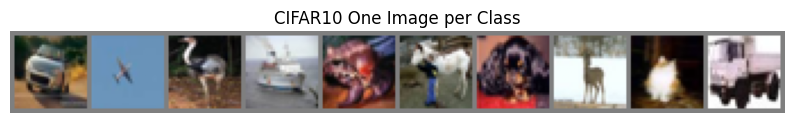

In [6]:
# Load the CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloaderview = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# CIFAR10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to un-normalize and display an image
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize if normalized earlier
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')  # Hide axis for cleaner display
    plt.show()

# Dictionary to hold one image from each class
class_images = {}

# Loop through the dataset and collect one image for each class
for data in dataloaderview:
    images, labels = data
    label = labels.item()

    # If we haven't collected an image for this class yet
    if label not in class_images:
        class_images[label] = images[0]  # Extract the first image from the batch

    # Stop once we have an image for each class
    if len(class_images) == 10:
        break

# Display all images in a grid
all_images = [img for img in class_images.values()]
grid = torchvision.utils.make_grid(all_images, nrow=10)

# Display the grid
plt.figure(figsize=(10, 2)) 
imshow(grid, title="CIFAR10 One Image per Class")

### SECTION 05: Task1-conditional Wesserstein GAN
#### A **Conditional Wasserstein GAN (cWGAN)** builds on the WGAN by conditioning the generator and discriminator with **additional information**, such as labels or class identifiers. This enables the model to generate samples that meet specific conditions or categories.

* Conditional Generator Model & Conditional Discriminator Model with Gradient Penalty is used for training stability
* Adam optimizer is used for both Generator & Discriminator
* Three block
  * Generator, Discriminator
  * Training
  * Image generation, IS and FID 

In [7]:
# Conditional Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, img_size * img_size * channels),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), channels, self.img_size, self.img_size)
        return img

# Conditional Discriminator Model with Gradient Penalty
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(channels * img_size * img_size + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_embedding = self.label_emb(labels)
        d_in = torch.cat((img_flat, label_embedding), -1)
        validity = self.model(d_in)
        return validity

# Initialize models
generator = Generator(z_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Wrap models with DataParallel to use multiple GPUs
#generator = nn.DataParallel(generator, device_ids=device_ids).to(device)
#discriminator = nn.DataParallel(discriminator, device_ids=device_ids).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Gradient penalty for WGAN-GP
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [8]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        # Prepare inputs
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, z_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_imgs = generator(z, fake_labels)
        
        real_validity = discriminator(imgs, labels)
        fake_validity = discriminator(fake_imgs.detach(), fake_labels)
        
        gradient_penalty = compute_gradient_penalty(discriminator, imgs.data, fake_imgs.data, labels)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        
        d_loss.backward()
        optimizer_D.step()

        # Train generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)
            gen_validity = discriminator(gen_imgs, gen_labels)
            
            g_loss = -torch.mean(gen_validity)
            g_loss.backward()
            optimizer_G.step()
        '''
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, f'cWGAN_checkpoint_epoch_{epoch}.pth')
        '''
        # Print loss
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{n_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

Epoch [0/200] Batch 0/782                   Loss D: 8.157550811767578, Loss G: 0.11732648313045502
Epoch [0/200] Batch 100/782                   Loss D: -15.327474594116211, Loss G: 0.05718082934617996
Epoch [0/200] Batch 200/782                   Loss D: -22.958345413208008, Loss G: -1.494986653327942
Epoch [0/200] Batch 300/782                   Loss D: -16.187679290771484, Loss G: 1.7432472705841064
Epoch [0/200] Batch 400/782                   Loss D: -13.409677505493164, Loss G: -0.9657566547393799
Epoch [0/200] Batch 500/782                   Loss D: -12.615248680114746, Loss G: -0.19600167870521545
Epoch [0/200] Batch 600/782                   Loss D: -10.843473434448242, Loss G: 0.7466575503349304
Epoch [0/200] Batch 700/782                   Loss D: -10.360241889953613, Loss G: -0.2068408578634262
Epoch [1/200] Batch 0/782                   Loss D: -9.06343936920166, Loss G: -0.44986075162887573
Epoch [1/200] Batch 100/782                   Loss D: -9.097574234008789, Loss G: 

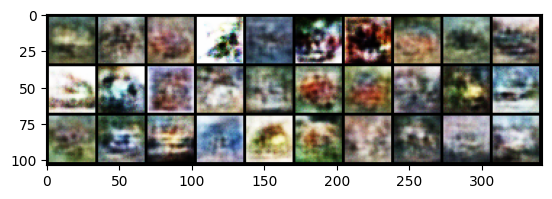

Inception Score: 1.887611985206604 ± 0.29383090138435364


/home/caisys/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


FID Score: 223.82562255859375


In [9]:
generate_images(generator, 30, label=1)

real_images = next(iter(dataloader))[0].to(device)  # Get real images from CIFAR-10
fake_images = generator(torch.randn(100, z_dim).to(device), torch.randint(0, num_classes, (100,)).to(device))  # Generate 100 fake images

# Compute Inception Score
is_mean, is_std = inception_score(fake_images, inception_model)
print(f"Inception Score: {is_mean} ± {is_std}")

# Compute FID Score
fid_value = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_value.item()}")

#### The above image is for cWGAN run on 200 epochs with IS = 1.88 and FID = 223.8

### SECTION 06: Task2-SNGAN
#### SNGAN uses **spectral normalization** to stabilize GAN training by **limiting the discriminator’s strength**, leading to better data quality.

In [10]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3*32*32),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 3, 32, 32)
        return x

# Define the Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            spectral_norm(nn.Linear(512*2*2, 1))
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

In [11]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)
        labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()

        outputs = discriminator(real_imgs)
        d_loss_real = criterion(outputs, labels)
        d_loss_real.backward()

        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        outputs = discriminator(fake_imgs)
        g_loss = criterion(outputs, labels)
        g_loss.backward()

        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{n_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')

Epoch [1/200] | D Loss: 0.717144638299942 | G Loss: 1.5243563652038574
Epoch [2/200] | D Loss: 0.43472860753536224 | G Loss: 2.124466896057129
Epoch [3/200] | D Loss: 1.081495314836502 | G Loss: 1.1247889995574951
Epoch [4/200] | D Loss: 1.1285180747509003 | G Loss: 1.3103612661361694
Epoch [5/200] | D Loss: 0.8792823553085327 | G Loss: 1.4101369380950928
Epoch [6/200] | D Loss: 1.263033390045166 | G Loss: 1.1458461284637451
Epoch [7/200] | D Loss: 0.8667302429676056 | G Loss: 2.093634605407715
Epoch [8/200] | D Loss: 1.0224841237068176 | G Loss: 1.484351634979248
Epoch [9/200] | D Loss: 0.8328272998332977 | G Loss: 1.2601696252822876
Epoch [10/200] | D Loss: 1.0483198761940002 | G Loss: 1.314228892326355
Epoch [11/200] | D Loss: 1.0799727141857147 | G Loss: 1.5943470001220703
Epoch [12/200] | D Loss: 0.9449633061885834 | G Loss: 1.3260639905929565
Epoch [13/200] | D Loss: 1.0498635172843933 | G Loss: 1.270810842514038
Epoch [14/200] | D Loss: 1.0212368369102478 | G Loss: 1.17890143394

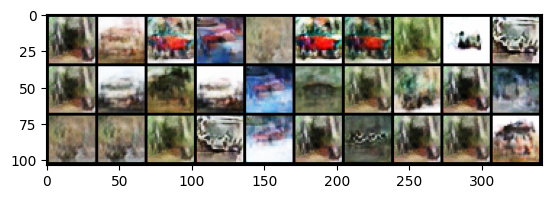

Inception Score: 2.8266730308532715 ± 0.4851420521736145
FID Score: 223.37899780273438


In [12]:
generate_images(generator, 30, label=999) # label 999 take it to mode where label is not relevant 

real_images = next(iter(dataloader))[0].to(device)  # Get real images from CIFAR-10
fake_images = generator(torch.randn(100, z_dim).to(device))  # Generate 100 fake images

# Compute Inception Score
is_mean, is_std = inception_score(fake_images, inception_model)
print(f"Inception Score: {is_mean} ± {is_std}")

# Compute FID Score
fid_value = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_value.item()}")

#### The above image is for SNGAN run on 200 epochs with IS = 2.83 and FID = 223.4

### SECTION 07: Task3-SAGAN(without spectral nornamization and TTUB)
#### Without spectral normalization and Two Time-Scale Update Rule (TTUR), SAGAN would face **instability**, as these techniques help balance the **discriminator's power** and **learning rates** during training.

In [13]:
# Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.init_size = 4
        self.fc = nn.Linear(z_dim, 512 * self.init_size * self.init_size)
        self.l1 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.attn = SelfAttention(128)  # Adding self-attention
        self.l3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 512, self.init_size, self.init_size)
        out = self.l1(out)
        out = self.l2(out)
        out = self.attn(out)  # Apply self-attention
        out = self.l3(out)
        return out

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 128, bn=False),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 512),
        )

        self.attn = SelfAttention(512)  # Adding self-attention
        self.adv_layer = nn.Linear(512 * 4 * 4, 1)  # This will be updated in `forward()`

    def forward(self, img):
        out = self.model(img)
        out = self.attn(out)  # Apply self-attention
        out = out.view(out.size(0), -1)  # Flatten the output
        
        # Compute the size dynamically instead of hardcoding
        if out.size(1) != 512 * 4 * 4:
            self.adv_layer = nn.Linear(out.size(1), 1).to(device)

        validity = self.adv_layer(out)
        return validity

# Instantiate models
generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
adversarial_loss = nn.BCEWithLogitsLoss()

In [14]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

        # Configure input
        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

[Epoch 0/200] [D loss: 0.7870654463768005] [G loss: 0.7116531729698181]
[Epoch 1/200] [D loss: 0.9650358557701111] [G loss: 0.7574159502983093]
[Epoch 2/200] [D loss: 0.8582509160041809] [G loss: 1.561589002609253]
[Epoch 3/200] [D loss: 0.7241950631141663] [G loss: 1.0341017246246338]
[Epoch 4/200] [D loss: 0.7439697980880737] [G loss: 0.4248211085796356]
[Epoch 5/200] [D loss: 0.7184557914733887] [G loss: 0.6337899565696716]
[Epoch 6/200] [D loss: 0.6876961588859558] [G loss: 0.6604176759719849]
[Epoch 7/200] [D loss: 0.852468729019165] [G loss: 0.8332571387290955]
[Epoch 8/200] [D loss: 0.7766947746276855] [G loss: 0.7809508442878723]
[Epoch 9/200] [D loss: 0.7575699687004089] [G loss: 0.6697486042976379]
[Epoch 10/200] [D loss: 0.7551157474517822] [G loss: 0.7898531556129456]
[Epoch 11/200] [D loss: 0.7189897298812866] [G loss: 0.6970508694648743]
[Epoch 12/200] [D loss: 0.7591894268989563] [G loss: 0.72459876537323]
[Epoch 13/200] [D loss: 0.6481760740280151] [G loss: 0.7065887451

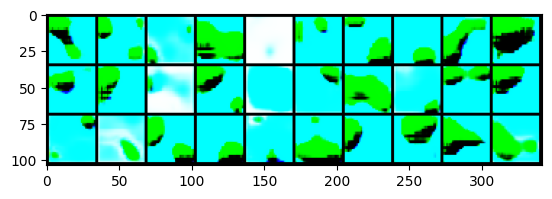

Inception Score: 2.7203917503356934 ± 0.2795594334602356
FID Score: 301.1747741699219


In [15]:
generate_images(generator, 30, label=999) # label 999 take it to mode where label is not relevant 

real_images = next(iter(dataloader))[0].to(device)  # Get real images from CIFAR-10
fake_images = generator(torch.randn(100, z_dim).to(device))  # Generate 100 fake images

# Compute Inception Score
is_mean, is_std = inception_score(fake_images, inception_model)
print(f"Inception Score: {is_mean} ± {is_std}")

# Compute FID Score
fid_value = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_value.item()}")

#### The above image is for SAGAN(without spectral nornamization and TTUB) run on 200 epochs with IS = 2.72 and FID = 301.2

### SECTION 08: Task3-SAGAN(Complete)
#### SAGAN, or Self-Attention GAN, uses **self-attention** to capture **long-range dependencies**, improving data generation quality, especially for **high-resolution** images.

In [16]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super(Generator, self).__init__()
        self.init_size = 8
        self.l1 = nn.Sequential(nn.Linear(z_dim, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(128),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 2, 1, 0),  # Change kernel size to 2 to match the input size
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(validity.size(0), -1)

generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCEWithLogitsLoss().to(device)

In [17]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

        real_imgs = imgs.to(device)

        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch}/{n_epochs}]  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

Epoch [0/200]  Loss D: 0.6975884437561035, loss G: 0.6862654089927673
Epoch [1/200]  Loss D: 0.9162967801094055, loss G: 0.42268165946006775
Epoch [2/200]  Loss D: 0.37549760937690735, loss G: 3.062056541442871
Epoch [3/200]  Loss D: 0.09148075431585312, loss G: 2.6217262744903564
Epoch [4/200]  Loss D: 0.5130825042724609, loss G: 0.9977596998214722
Epoch [5/200]  Loss D: 0.35448822379112244, loss G: 1.2634196281433105
Epoch [6/200]  Loss D: 0.20239925384521484, loss G: 1.8939836025238037
Epoch [7/200]  Loss D: 0.44200366735458374, loss G: 2.9997920989990234
Epoch [8/200]  Loss D: 0.7739418745040894, loss G: 1.4629490375518799
Epoch [9/200]  Loss D: 0.37494468688964844, loss G: 1.059541940689087
Epoch [10/200]  Loss D: 0.602637767791748, loss G: 0.7204311490058899
Epoch [11/200]  Loss D: 0.10046853125095367, loss G: 4.035457611083984
Epoch [12/200]  Loss D: 0.23496001958847046, loss G: 2.7615089416503906
Epoch [13/200]  Loss D: 0.1513316035270691, loss G: 3.4581563472747803
Epoch [14/2

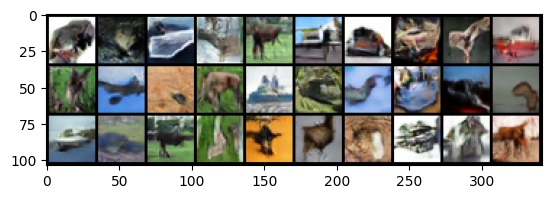

Inception Score: 4.477306365966797 ± 0.9563080072402954
FID Score: 174.62640380859375


In [18]:
generate_images(generator, 30, label=999) # label 999 take it to mode where label is not relevant 

real_images = next(iter(dataloader))[0].to(device)  # Get real images from CIFAR-10
fake_images = generator(torch.randn(100, z_dim).to(device))  # Generate 100 fake images

# Compute Inception Score
is_mean, is_std = inception_score(fake_images, inception_model)
print(f"Inception Score: {is_mean} ± {is_std}")

# Compute FID Score
fid_value = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_value.item()}")

#### The above image is for SAGAN(Complete) run on 200 epochs with IS = 4.48 and FID = 174.63

## SECTION 09: Task5-Result Explaination

| Model                              | Epochs | IS (Inception Score) | FID (Fréchet Inception Distance) |
|------------------------------------|--------|----------------------|----------------------------------|
| cWGAN                              | 200    | 1.88                 | 223.8                            |
| SNGAN                              | 200    | 2.83                 | 223.4                            |
| SAGAN (without spectral normalization and TTUB) | 200    | 2.72                 | 301.2                            |
| SAGAN (Complete)                   | 200    | 4.48                 | 174.63                           |

1. **cWGAN (Conditional Wasserstein GAN):**

   **IS = 1.88, FID = 223.8**

   **Analysis:**
    * The Inception Score (IS) of 1.88 indicates relatively low diversity and image quality, meaning the generated images are not highly distinguishable or diverse.
    * The FID score of 223.8 suggests that the generated images still differ significantly from the real images in terms of distribution, indicating that realism is moderate.
    
    **Summary:** cWGAN demonstrates moderate performance with acceptable quality but lacks in terms of generating highly realistic and diverse images.
      
3. **SNGAN (Spectral Normalization GAN):**

   **IS = 2.83, FID = 223.4**

    **Analysis:**
    * With an IS of 2.83, SNGAN is generating more diverse and distinguishable images than cWGAN. A higher IS implies better variety in the generated images.
    * The FID score of 223.4 indicates that the generated images are somewhat realistic but still distant from the true data distribution. The FID is slightly lower than that of cWGAN, which suggests a slight improvement in realism.
      
    **Summary:** SNGAN offers a better balance of diversity and realism than cWGAN, though there is room for improvement in terms of image realism.

   
5. **SAGAN (without spectral normalization and TTUB):**

   **IS = 2.72, FID = 301.2**

    **Analysis:**
    * The IS score of 2.72 suggests that the model produces images with good diversity, although slightly less so than SNGAN.
    * The FID score of 301.2 is quite high, indicating that the generated images are much less realistic. The absence of spectral normalization and TTUB likely leads to reduced training stability, causing the images to be of lower quality.
      
    **Summary:** Although the diversity is good, SAGAN without spectral normalization and TTUB struggles to generate realistic images, leading to poor performance in terms of realism.
      
7. **SAGAN (Complete):**

   **IS = 4.48, FID = 174.63**

    **Analysis:**
    * The IS score of 4.48 is the highest among all models, reflecting excellent diversity and quality in the generated images. A higher IS suggests that the model is generating a wide range of distinguishable and diverse images.
    * The FID score of 174.63 is the lowest, meaning that the generated images are much closer to real-world images in terms of both quality and distribution. The combination of spectral normalization and TTUB likely contributes to this strong performance.

    **Summary:** SAGAN (Complete) performs the best overall, offering the highest diversity and the most realistic images, thanks to the inclusion of advanced techniques like spectral normalization and TTUB.

**Results:**
* cWGAN shows modest performance, producing acceptable but not outstanding results in terms of diversity and realism.
* SNGAN improves on cWGAN with better diversity and realism but still does not achieve top-tier image quality.
* SAGAN without SN and TTUB demonstrates good diversity but poor realism, highlighting the importance of those techniques for improving image quality.
* SAGAN (Complete) is the top performer, with the best balance of diversity and realism, achieving superior results thanks to spectral normalization and TTUB.

## **-----End of Document-----**